<a href="https://colab.research.google.com/github/jademuun/car_insurance_MTPL/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version

Python 3.7.10


# Libraries

In [125]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import countplot
from matplotlib.pyplot import figure, show
import timeit

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K

import probflow as pf


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data load and preprocessing

In [126]:
# data can be downloaded from
# however they are not in good format as delimiter is chosen badly
# people from Masaryk Uni can access the dataset via 
#https://drive.google.com/file/d/19eCVbFxIbs6uwe7w5MPsdcYNh0uILPfJ/view?usp=sharing
claim = pd.read_csv('/content/drive/MyDrive/data/freMTPL2freq.csv')
claim = claim.drop(claim.columns[0], axis = 1)

In [127]:
claim.head()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
0,1.0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
1,3.0,1,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
2,5.0,1,0.75,6,2,52,50,B12,Diesel,B,54,Picardie
3,10.0,1,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine
4,11.0,1,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine


In [128]:
claim.shape

(678013, 12)

In [129]:
claim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   VehPower    678013 non-null  int64  
 4   VehAge      678013 non-null  int64  
 5   DrivAge     678013 non-null  int64  
 6   BonusMalus  678013 non-null  int64  
 7   VehBrand    678013 non-null  object 
 8   VehGas      678013 non-null  object 
 9   Area        678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


In [130]:
# obect columns are not good for model training, so we change their
# datatype to category
numerics_cols = ['int64', 'float64']
object_cols = claim.select_dtypes("object").columns  # select object columns
claim[object_cols] = claim[object_cols].astype('category')


In [131]:
claim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678013 non-null  float64 
 1   ClaimNb     678013 non-null  int64   
 2   Exposure    678013 non-null  float64 
 3   VehPower    678013 non-null  int64   
 4   VehAge      678013 non-null  int64   
 5   DrivAge     678013 non-null  int64   
 6   BonusMalus  678013 non-null  int64   
 7   VehBrand    678013 non-null  category
 8   VehGas      678013 non-null  category
 9   Area        678013 non-null  category
 10  Density     678013 non-null  int64   
 11  Region      678013 non-null  category
dtypes: category(4), float64(2), int64(6)
memory usage: 44.0 MB


In [132]:
# drop index number
claim = claim.drop(['IDpol'], axis = 1)
# x is dataset of all 8 features, first column is target while second is
# time exposure - offset 
claim.head()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
1,1,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
2,1,0.75,6,2,52,50,B12,Diesel,B,54,Picardie
3,1,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine
4,1,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine


In [134]:
# numerical characteristics of dataset
claim.describe(exclude='category')

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [135]:
claim.describe(include='category')

,VehBrand,VehGas,Area,Region
count,678013,678013,678013,678013
unique,11,2,6,21
top,B12,Regular,C,Centre
freq,166024,345877,191880,160601


Tu pojde tabulka so strany 2,
pod nou dat coment ze proste 4 a viac dame do jednej kedze to je velmi malo pravdepodobne ze niekdeto mal tolko, tak to dame rovne 4



In [136]:
sum(claim.Exposure > 1)

1224

In [138]:
# the maximum observing time was one year, so, these must have been a mistake, we replace them with 1 as Wutrich
claim.loc[claim.Exposure > 1,'Exposure'] = 1

0

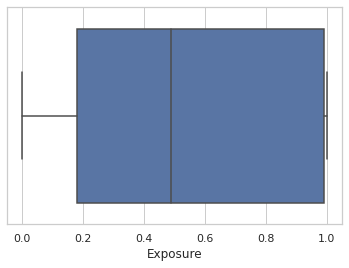

In [139]:
# boxplot for exposition period distribution
sns.set_theme(style="whitegrid")
sns.boxplot(x = 'Exposure', data = claim)

Text(0.5, 0, 'Exposure')

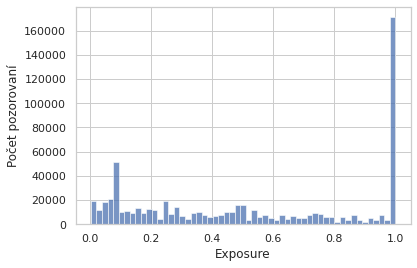

In [140]:
ax = sns.histplot(x = 'Exposure', data = claim)
sns.set_theme(style="whitegrid")
ax.set_ylabel("Počet pozorovaní")
ax.set_xlabel("Exposure")

In [141]:
# we dont expect more than 4 claims during a fiscal year
claim.loc[claim.ClaimNb > 3, "ClaimNb"] = 4

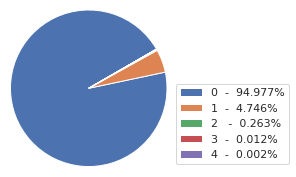

In [142]:
# pie plot showing the distribution of claim counts

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
dat = claim.ClaimNb.value_counts()

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)


wedges, autotexts = ax.pie(dat, startangle = 30, radius = 1.2, textprops=dict(color="w"))

ax.legend(wedges, ['0  -  94.977%','1  -  4.746%','2   -  0.263%','3  -  0.012%', '4  -  0.002%'],
                    loc="lower left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

plt.show()

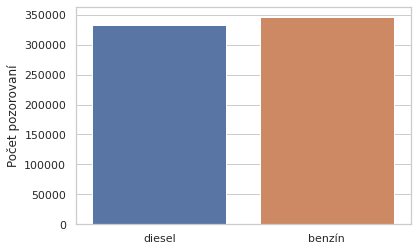

In [143]:
# Distribution of type of fuel
ax = countplot(data=claim,x='VehGas')
ax.set_xticklabels(["diesel","benzín"])
ax.set_ylabel("Počet pozorovaní")
ax.set_xlabel("")

show()

In [145]:
claim.loc[claim.VehAge > 40, 'VehAge'].value_counts().sum()

230

In [146]:
claim.loc[claim.DrivAge > 90].value_counts().sum()

401

In [147]:
claim.loc[claim.BonusMalus > 150].value_counts().sum()

209

In [148]:
claim = claim.loc[claim.VehAge < 40]
claim = claim.loc[claim.DrivAge < 90]
claim = claim.loc[claim.BonusMalus < 150]



In [79]:
# correlation between numerical features
claim.corr()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
ClaimNb,1.000000,0.069744,-0.003987,-0.022181,0.011312,0.051182,0.010924
Exposure,0.069744,1.000000,-0.045398,0.151644,0.172016,-0.183089,-0.071196
VehPower,-0.003987,-0.045398,1.000000,-0.006001,0.030108,-0.075895,0.042901
VehAge,-0.022181,0.151644,-0.006001,1.000000,-0.059213,0.079923,-0.090428
DrivAge,0.011312,0.172016,0.030108,-0.059213,1.000000,-0.479966,-0.004700
BonusMalus,0.051182,-0.183089,-0.075895,0.079923,-0.479966,1.000000,0.077717
Density,0.010924,-0.071196,0.042901,-0.090428,-0.004700,0.077717,1.000000


# Scaling and one-hot-encoding

In [ ]:
onehot = OneHotEncoder()
gasenc = LabelEncoder()
minmax = MinMaxScaler(feature_range=(-1 , 1))
claim

In [150]:
# transform area to numeric categories - ordinal
claim['Area'] = claim['Area'].cat.codes

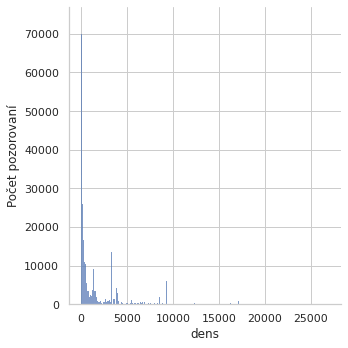

In [151]:
ax = sns.displot(x = 'Density', data = claim)
ax.set(xlabel='dens', ylabel='Počet pozorovaní')
plt.show()

In [152]:
claim[['minmaxlogdense']] = minmax.fit_transform(claim[['Density']])

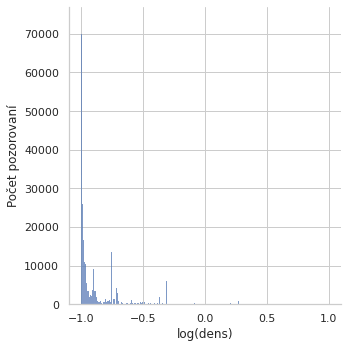

In [153]:
ax=sns.displot(x = 'minmaxlogdense', data = claim)
ax.set(xlabel='log(dens)', ylabel='Počet pozorovaní')
plt.show()

In [154]:
# transform dens to log dens (we follow the initial article of 
# M. V. Wuthrich - Data Analytics for Non-Life Insurance Pricing, 2020)
claim['Density'] = np.log(claim['Density'])


In [155]:
# correlation of numerical features 
# significant correlation between area and dens
claim = claim.drop('minmaxlogdense', axis = 1)


In [156]:
claim.corr()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Area,Density
ClaimNb,1.000000,0.069713,-0.003930,-0.022187,0.011269,0.049813,0.013443,0.014257
Exposure,0.069713,1.000000,-0.045262,0.153336,0.170824,-0.183712,-0.122053,-0.122322
VehPower,-0.003930,-0.045262,1.000000,-0.005880,0.031112,-0.076223,0.003161,0.004872
VehAge,-0.022187,0.153336,-0.005880,1.000000,-0.062329,0.081453,-0.105547,-0.104786
DrivAge,0.011269,0.170824,0.031112,-0.062329,1.000000,-0.483303,-0.044973,-0.044511
BonusMalus,0.049813,-0.183712,-0.076223,0.081453,-0.483303,1.000000,0.120986,0.125391
Area,0.013443,-0.122053,0.003161,-0.105547,-0.044973,0.120986,1.000000,0.970616
Density,0.014257,-0.122322,0.004872,-0.104786,-0.044511,0.125391,0.970616,1.000000


In [157]:
# numerical we use min max scaler to map to interval [-1,1]
claim[['VehAge', 'VehPower', 'DrivAge', 'Density', 'BonusMalus', 'Area']] = minmax.fit_transform(claim[['VehAge', 'VehPower', 'DrivAge', 'Density', 'BonusMalus', 'Area']])

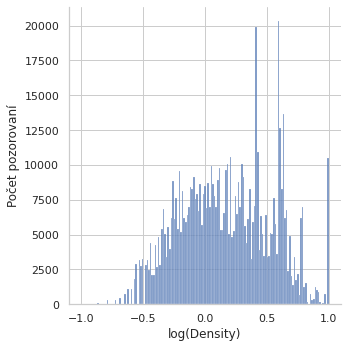

In [158]:
ax = sns.displot(x = 'Density', data = claim)
ax.set(xlabel='log(Density)', ylabel='Počet pozorovaní')
plt.show()

In [159]:
# gas is transformed into two categories, -1.5, +1.5
claim['VehGas'] = claim.VehGas.factorize()[0] - 0.5

In [160]:
# One hot encoding with drop first
claim = pd.get_dummies(claim, drop_first=True, columns = ['VehBrand', 'Region'])

In [161]:
claim.head()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Area,Density,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,Region_Aquitaine,Region_Auvergne,Region_Basse-Normandie,Region_Bourgogne,Region_Bretagne,Region_Centre,Region_Champagne-Ardenne,Region_Corse,Region_Franche-Comte,Region_Haute-Normandie,Region_Ile-de-France,Region_Languedoc-Roussillon,Region_Limousin,Region_Midi-Pyrenees,Region_Nord-Pas-de-Calais,Region_Pays-de-la-Loire,Region_Picardie,Region_Poitou-Charentes,Region_Provence-Alpes-Cotes-D'Azur,Region_Rhone-Alpes
0,1,0.10,-0.818182,-1.000000,0.042254,-1.0,-0.5,0.2,0.392479,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0.77,-0.818182,-1.000000,0.042254,-1.0,-0.5,0.2,0.392479,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0.75,-0.636364,-0.897436,-0.042254,-1.0,0.5,-0.6,-0.218122,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0.09,-0.454545,-1.000000,-0.211268,-1.0,0.5,-0.6,-0.151136,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.84,-0.454545,-1.000000,-0.211268,-1.0,0.5,-0.6,-0.151136,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [162]:
claim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676990 entries, 0 to 678012
Data columns (total 39 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ClaimNb                             676990 non-null  int64  
 1   Exposure                            676990 non-null  float64
 2   VehPower                            676990 non-null  float64
 3   VehAge                              676990 non-null  float64
 4   DrivAge                             676990 non-null  float64
 5   BonusMalus                          676990 non-null  float64
 6   VehGas                              676990 non-null  float64
 7   Area                                676990 non-null  float64
 8   Density                             676990 non-null  float64
 9   VehBrand_B10                        676990 non-null  uint8  
 10  VehBrand_B11                        676990 non-null  uint8  
 11  VehBrand_B12              

In [163]:
claim.to_csv('/content/drive/MyDrive/data/scaled.csv')